In [3]:
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
from IrisLocalization import *
from IrisNormalization import normalize_iris
from IrisEnhancement import enhance_iris
from FeatureExtraction import extract_feature
from PerformanceEvaluation import * 
from IrisMatching import run_lda_analysis


In [4]:
def extract_all_features(base_dir, is_training=True):
    """
    Extract features for all images in the dataset
    Returns: features array, labels array
    """
    features = []
    labels = []
    base = Path(base_dir)
    
    angles = [0] if is_training else [-9, -6, -3, 0, 3, 6, 9]
    
    for subject in tqdm(range(1, 109), desc="Processing subjects"):
        subject_dir = f"{subject:03d}"
        subset = '1' if is_training else '2'
        current_dir = base / subject_dir / subset
        
        if not current_dir.exists():
            continue
            
        for img_file in current_dir.glob('*.bmp'):
            image = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
            final_pupil_center, pupil_radius, iris_circle = detect_iris_and_pupil(str(img_file))
            
            if final_pupil_center and iris_circle:
                for angle in angles:
                    normalized_iris = normalize_iris(image, final_pupil_center, 
                                                  pupil_radius, iris_circle, 
                                                  initial_angle=angle)
                    enhanced_iris = enhance_iris(normalized_iris)
                    feature = extract_feature(enhanced_iris)
                    features.append(feature)
                    labels.append(subject)
    
    return np.array(features), np.array(labels)

In [ ]:
# Main execution
base_dir = r".\datasets\CASIA Iris Image Database (version 1.0)"

# Extract features
print("Extracting training features...")
train_features, train_labels = extract_all_features(base_dir, is_training=True)
print("Extracting testing features...")
test_features, test_labels = extract_all_features(base_dir, is_training=False)

# Compute templates for original features
templates = compute_templates(train_features, train_labels)

Extracting training features...


Processing subjects: 100%|██████████| 108/108 [00:16<00:00,  6.74it/s]


Extracting testing features...


Processing subjects: 100%|██████████| 108/108 [01:51<00:00,  1.03s/it]


In [6]:
# Evaluate original features
print("Evaluating original features...")
acc_l1, acc_l2, acc_cos = evaluate_recognition(test_features, test_labels, templates)
print(f"Original Features Accuracies:")
print(f"L1: {acc_l1:.4f}")
print(f"L2: {acc_l2:.4f}")
print(f"Cosine: {acc_cos:.4f}")

Evaluating original features...
Original Features Accuracies:
L1: 0.8588
L2: 0.8333
Cosine: 0.8241


Performing LDA analysis...


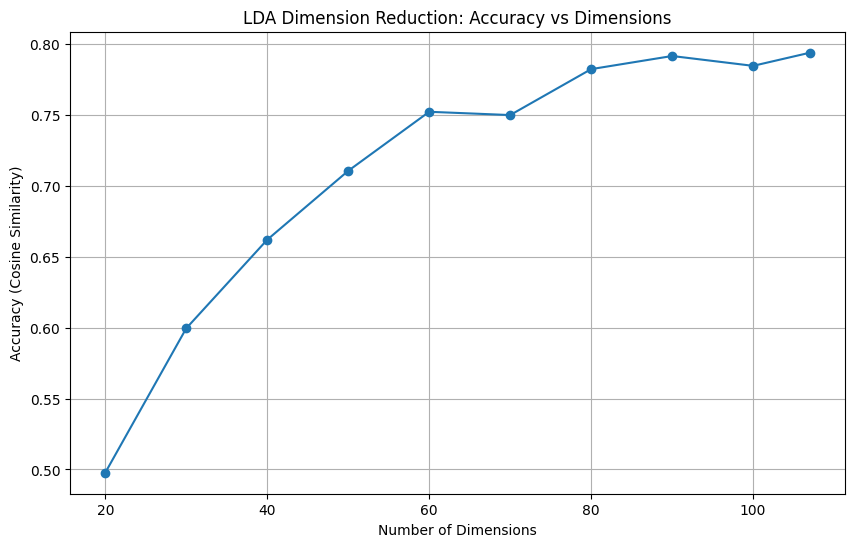

In [8]:
# LDA Analysis
dimensions = [107,100, 90, 80, 70, 60, 50, 40, 30, 20]
print("Performing LDA analysis...")
lda_results = run_lda_analysis(train_features, train_labels, test_features, test_labels, dimensions)

# Create accuracy vs dimensions plot
plt.figure(figsize=(10, 6))
plt.plot(dimensions, lda_results[:, 3], marker='o')
plt.xlabel('Number of Dimensions')
plt.ylabel('Accuracy (Cosine Similarity)')
plt.title('LDA Dimension Reduction: Accuracy vs Dimensions')
plt.grid(True)
plt.show()

In [10]:
# Print comparison table
print("\nComparison Results:")
print("-" * 60)
print(f"{'Metric':<15} {'Original':<15} {'LDA (107d)':<15} {'Difference':<15}")
print("-" * 60)

# Get LDA results for 107 dimensions (first row of lda_results)
lda_l1, lda_l2, lda_cos = lda_results[0, 1], lda_results[0, 2], lda_results[0, 3]

# Print results with differences
print(f"{'L1 Distance':<15} {acc_l1:>14.4f} {lda_l1:>14.4f} {(lda_l1-acc_l1):>14.4f}")
print(f"{'L2 Distance':<15} {acc_l2:>14.4f} {lda_l2:>14.4f} {(lda_l2-acc_l2):>14.4f}")
print(f"{'Cosine':<15} {acc_cos:>14.4f} {lda_cos:>14.4f} {(lda_cos-acc_cos):>14.4f}")
print("-" * 60)


Comparison Results:
------------------------------------------------------------
Metric          Original        LDA (107d)      Difference     
------------------------------------------------------------
L1 Distance             0.8588         0.7546        -0.1042
L2 Distance             0.8333         0.7731        -0.0602
Cosine                  0.8241         0.7940        -0.0301
------------------------------------------------------------


Analyzing verification performance for original features...

Verification Results at Different Thresholds:
Threshold    False match rate (%)    False non-match rate (%)
------------------------------------------------------------
0.967        0.010                   57.41
0.970        0.001                   70.14
0.971        0.000                   72.69


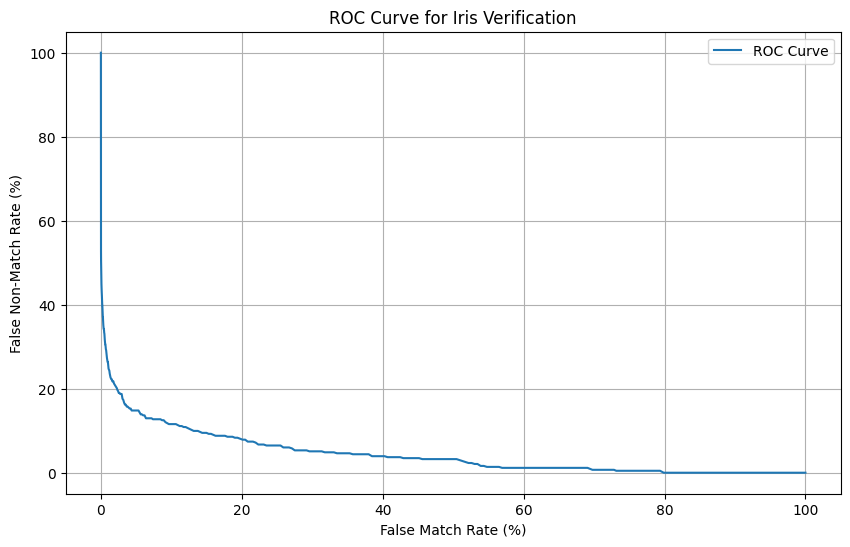


Analyzing verification performance for LDA features...

Verification Results at Different Thresholds:
Threshold    False match rate (%)    False non-match rate (%)
------------------------------------------------------------
0.453        0.010                   29.63
0.525        0.001                   47.69
0.573        0.000                   63.89


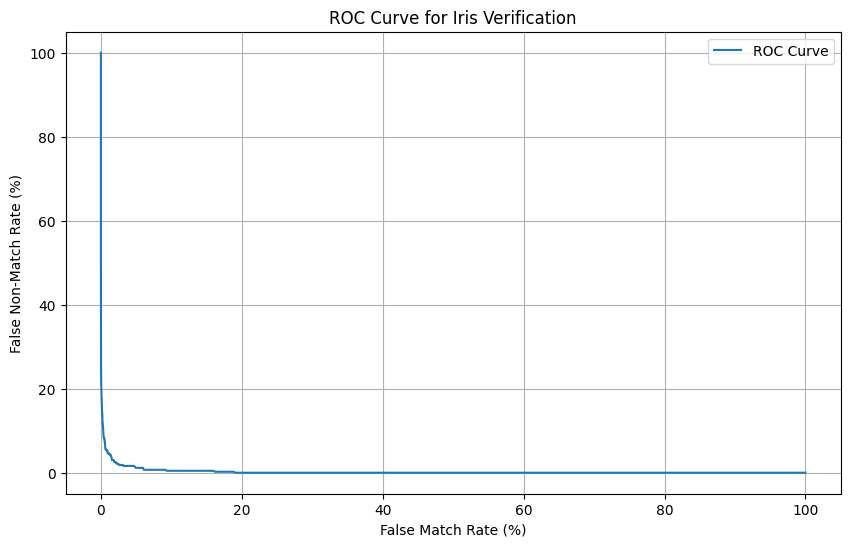

In [ ]:
# Main execution
template_labels = np.arange(1, 109)  # Correctly labels templates from 1 to 108


# For original features
print("Analyzing verification performance for original features...")
templates = compute_templates(train_features, train_labels)
original_results, genuine_scores, impostor_scores = plot_roc_and_metrics(
    test_features, test_labels, templates, template_labels
)
#plot_score_distributions(genuine_scores, impostor_scores)

# For LDA features (using 100 dimensions as example)
print("\nAnalyzing verification performance for LDA features...")
lda = LinearDiscriminantAnalysis(n_components=100)
lda.fit(train_features, train_labels)
train_transformed = lda.transform(train_features)
test_transformed = lda.transform(test_features)
templates_lda = compute_templates(train_transformed, train_labels)
lda_results, genuine_scores_lda, impostor_scores_lda = plot_roc_and_metrics(
    test_transformed, test_labels, templates_lda, template_labels
)
#plot_score_distributions(genuine_scores_lda, impostor_scores_lda)

